1\. **2D minimization of a six-hump camelback function**

$$f(x,y) = \left(4-2.1x^2+\frac{x^4}{3} \right) x^2 +xy + (4y^2 -4)y^2$$

has multiple global and local minima.

- Find the global minima of this function
- How many global minima are there, and what is the function value at those points?
- What happens for an initial guess of $(x, y) = (0, 0)$?

Hints:

* Variables can be restricted to $-2 < x < 2$ and $-1 < y < 1$.
* Use `numpy.meshgrid()` and `pylab.imshow()` to graphically display the regions.
* Use `scipy.optimize.minimize()`, trying its optional arguments.

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


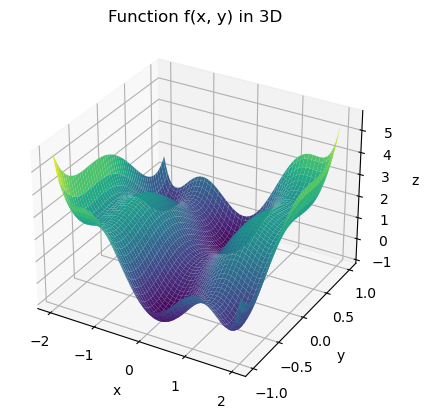

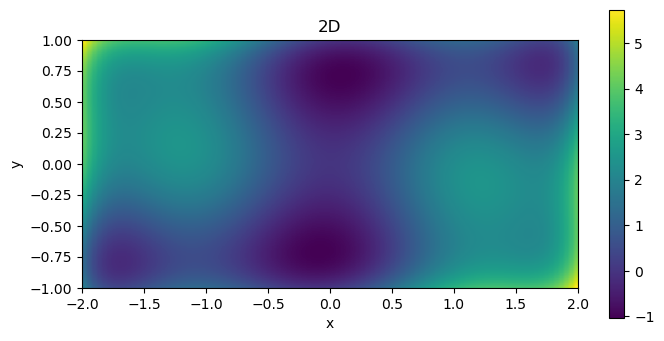

Minimum in: [ 0.08984201 -0.71265641]  with value: -1.0316284534898765
Minimum in: [-0.08984202  0.7126564 ]  with value: -1.0316284534898768
If i start from (0,0)...
Minimum in: [0. 0.]  with value: 0.0


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

def f(x, y):
    return (4 - 2.1*x**2 + x**4 / 3)*x**2 + x*y + (4 * y**2 - 4)*y**2

def f_vec(x):
    return (4 - 2.1*x[0]**2 + x[0]**4 / 3)*x[0]**2 + x[0]*x[1] + (-4 + 4*x[1]**2) * x[1]**2

x = np.linspace(-2, 2, 100)
y = np.linspace(-1, 1, 100)
X, Y = np.meshgrid(x, y)
Z = f(X, Y)

# 3D plot
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, Z, cmap='viridis')
ax.set_title('Function f(x, y) in 3D')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.show()

# 2D plot
fig = plt.figure(figsize=(8,4))
plt.title('2D')
plt.imshow(Z, extent = [-2, 2, -1, 1])
plt.xlabel('x')
plt.ylabel('y')
plt.colorbar()
plt.show()

#Find global minima
min1 = minimize(f_vec, x0 = (2,-1))
print("Minimum in:", min1['x']," with value:",min1['fun'])
min2 = minimize(f_vec, x0 = (-2,1))
print("Minimum in:", min2['x']," with value:",min2['fun'])

#if i start from (0,0) i found a local minima
print("If i start from (0,0)...")
min_00 = minimize(f_vec, x0 = (0,0))
print("Minimum in:", min_00['x']," with value:", min_00['fun'])

2\. **Non-linear ODE: the damped pendulum**

The equation of the motion of a forced pendulum, as a function of the angle $\theta$ with the vertical, is given by:

$$\frac{d^2\theta}{dt^2} = -\frac{1}{Q} \frac{d\theta}{dt} + \frac{g}{l}\sin\theta + d \cos\Omega t$$

where $t$ is time, $Q$ is the damping factor, $d$ is the forcing amplitude, and $\Omega$ is the driving frequency of the forcing. 

This second order ODE needs to be written as two coupled first order ODEs by defining a new variable $\omega \equiv d\theta/dt$:

$$\frac{d\theta}{dt} = \omega$$
$$\frac{d\omega}{dt} = -\frac{1}{Q}\,\omega + \frac{g}{l}\sin\theta + d \cos\Omega t$$

Consider the initial conditions $\theta_0 = \omega_0 = 0$, and $l = 10$, $Q = 2.0$, $d = 1.5$, and $\omega = 0.65$.

 - Solve the ODE with `odeint` over a period of 200 time steps
 - Create two plots, one of $\theta$ as a function of the time, and $\omega$ as a function of the time
 - **Optional**: determine if there is a set of parameters for which the motion is chaotic.

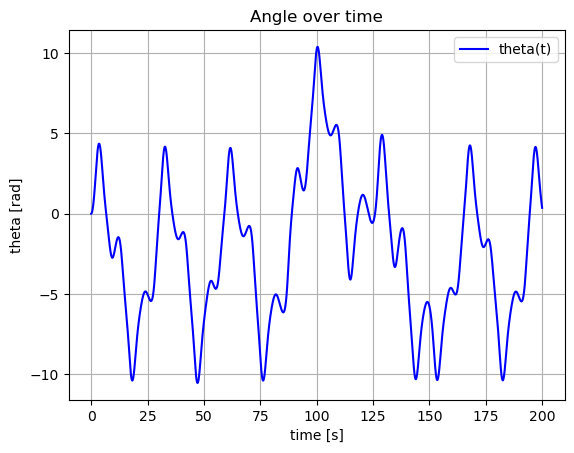

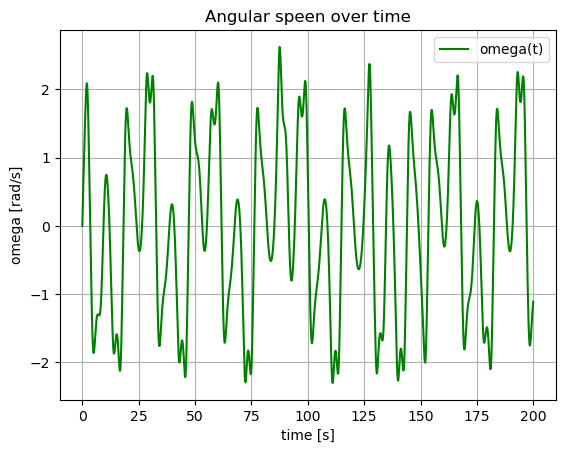

In [2]:
from scipy.integrate import odeint

def pendulum(y, t, Q, d, omega):
    theta, w = y
    dydt = [w, -w/Q + np.sin(theta) + d*np.cos(omega*t)]
    return dydt

# Initial conditions
theta0 = 0
w0 = 0
y0 = [theta0, w0]
Q = 2
d = 1.5
w = 0.65
t = np.linspace(0, 200, 2000)
#Computing the solutions
sol = odeint(pendulum, y0, t, args=(Q, d, w))
# Plotting the solutions
fig = plt.figure()
plt.plot(t, sol[:, 0], 'b', label='theta(t)')
plt.legend(loc='best')
plt.xlabel('time [s]')
plt.ylabel('theta [rad]')
plt.title('Angle over time')
plt.grid()
plt.show()

fig = plt.figure()
plt.plot(t, sol[:, 1], 'g', label='omega(t)')
plt.legend(loc='best')
plt.xlabel('time [s]')
plt.ylabel('omega [rad/s]')
plt.title('Angular speen over time')
plt.grid()
plt.show()

3\. **FFT of a simple dataset**

Perform a periodicity analysis on the lynxs-hares population, i.e. determine what is the period of the population of these animals.

The dataset is the one downloaded at the beginning of Lecture 06:

 - `!wget https://www.dropbox.com/s/ebe1cnyd2gm836a/populations.txt -P data/`

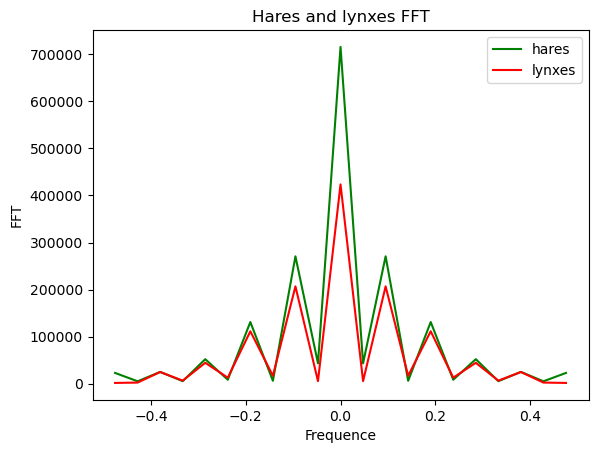

The period for the hares population is 10.5 years.
The period for the lynxes population is 10.5 years.


In [3]:
import scipy.fft as fft

data = np.loadtxt('data/populations.txt')
year = data[:,0]
hares = data[:,1]
lynxes = data[:,2]
carrots = data[:,3]

#Perform FFT on the population
hares_fft = fft.fft(hares)
lynxes_fft = fft.fft(lynxes)

#Compute the frequency axis
hares_freq = fft.fftfreq(len(hares_fft),1)
lynxes_freq = fft.fftfreq(len(lynxes_fft),1)

#Plot FFT
fig = plt.figure()
plt.plot(fft.fftshift(hares_freq), abs(fft.fftshift(hares_fft)), 'g', label="hares")
plt.plot(fft.fftshift(lynxes_freq), abs(fft.fftshift(lynxes_fft)),'r', label="lynxes")
plt.title('Hares and lynxes FFT')
plt.xlabel('Frequence')
plt.ylabel('FFT')
plt.legend(loc="best")
plt.show()

#Select only positive frequencies
mask_hares = np.where(hares_freq>0)
mask_lynxes = np.where(hares_freq>0)
hfreq = hares_freq[mask_hares]
lfreq = lynxes_freq[mask_lynxes]
pos_l = np.abs(lynxes_fft)[mask_lynxes]
pos_h = np.abs(hares_fft)[mask_hares]

#find the max frequency, then the period of the population
max_freq_h = hfreq[pos_h.argmax()]
max_freq_l = lfreq[pos_l.argmax()]
period_h = 1/max_freq_h
period_l = 1/max_freq_l
print("The period for the hares population is", period_h, "years.")
print("The period for the lynxes population is", period_l, "years.")

4\. **FFT of an image**

Write a filter that removes the periodic noise from the `moonlanding.png` image by using a 2-dimensional FFT.

* Import the image as a 2D numpy array using `plt.imread("images/moonlanding.png")`. Examine the image with `plt.imshow()`, which is heavily contaminated with periodic noise.
* Check the documentation of the `scipy.fftpack` package, and find the method that performs a 2D FFT. Plot the spectrum (Fourier transform of) the image. **Hint**: use `LogNorm` to plot the colors in log scale:
```Python
from matplotlib.colors import LogNorm
plt.imshow(image, norm=LogNorm(vmin=5))
```
* Inspect the spectrum, and try to locate the 2D regions of the power spectrum that contain the signal and those which contain the periodic noise. Use array slicing to set the noise regions to zero.
* Apply the inverse Fourier transform to plot the resulting image.

Text(0.5, 1.0, 'Reconstructed image')

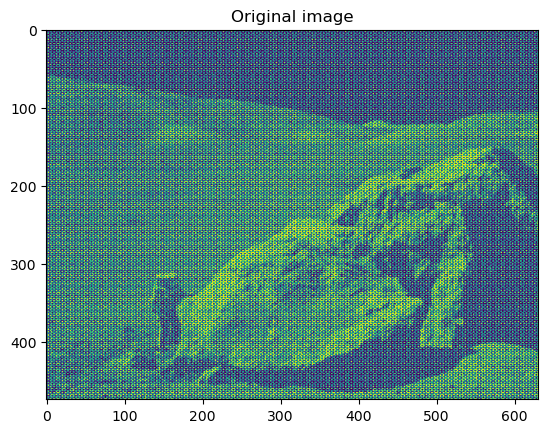

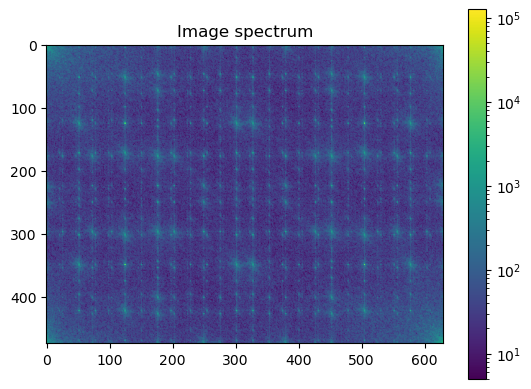

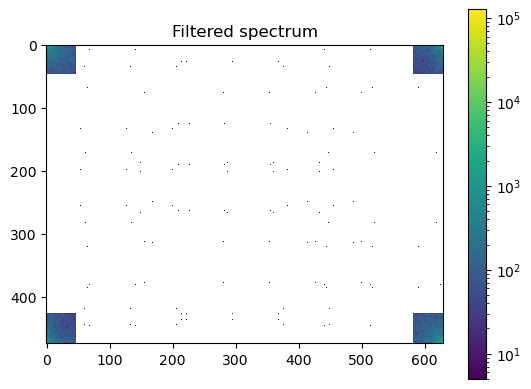

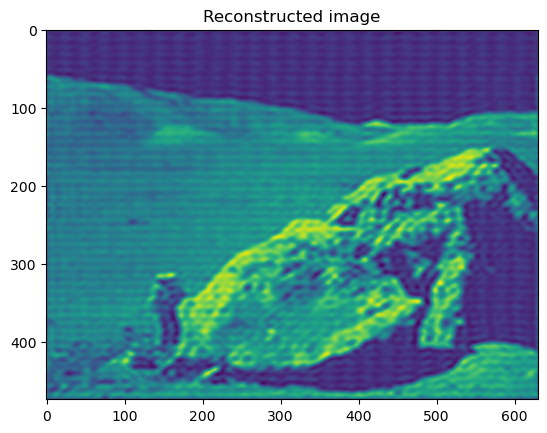

In [39]:
img = plt.imread("images/moonlanding.png")
plt.figure()
plt.imshow(img)
plt.title("Original image")
img_fft = fft.fft2(img)
plt.figure()
plt.imshow(abs(img_fft), norm=LogNorm(vmin=5))
plt.colorbar()
plt.title("Image spectrum")

#I select squares at the border of the spectrum because it seems there is less noise there
square = int(img.shape[0]/10)
img_fft[square:img.shape[0]-square, :] = 0
img_fft[:, square:img.shape[1]-square] = 0
plt.figure()
plt.imshow(abs(img_fft), norm=LogNorm(vmin=5))
plt.colorbar()
plt.title("Filtered spectrum")
filtered = fft.ifft2(img_fft).real
plt.figure()
plt.imshow(filtered)
plt.title("Reconstructed image")